# 🗃️ Data Processing

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

from src import utils

## 1. Remove Blank Images

These blank images won't provide any meaningful benefit to the training or testing so they need to be removed.

In [2]:
# Read in the csv list of all blank images
black_images_df = pd.read_csv(os.path.join(utils.METADATA_DIR, 'dvb_black_images.csv'))

In [4]:
# For each image file in the dataframe move it and its annotation file to a new folder
blank_img_dir = "data\\interim\\junk_data\\blank images and with their annotations"

for index, row in black_images_df.iterrows():
    img_file = row['file_name']
    ann_file = img_file.replace('.png', '.txt')
    # Move the image file
    os.rename(img_file, os.path.join(blank_img_dir, os.path.basename(img_file)))
    # Move the annotation file
    os.rename(ann_file, os.path.join(blank_img_dir, os.path.basename(ann_file)))

## 2. Fix Lagging Annotations

File `2019_10_16_C0003_3633_inspire` had some issues with the annotations that were discovered during the data exploration. The annotations were lagging behind the actual object. An additional 24 frames (approximately 1 second of video) were in the annotation file that are absent from the actual video file. Shifting the annotations by 24 frames should make the annotations line up correctly.

In [9]:
# Get a list of the image files
inspire_img_files = utils.files.get_image_files(os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data'))

In [10]:
len(inspire_img_files)

106443

In [11]:
# Reduce the list of image files to just the files that contain 2019_10_16_C0003_3633_inspire
inspire_img_files = [f for f in inspire_img_files if '2019_10_16_C0003_3633_inspire' in f]

In [13]:
num_imgs =len(inspire_img_files)
num_imgs

1402

In [5]:
# Get a list of the annotation files
inspire_ann_files = utils.files.get_annotation_files(os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data'))

In [6]:
len(inspire_ann_files)

106444

In [7]:
# Reduce the list of annotation files to just the files that contain 2019_10_16_C0003_3633_inspire
inspire_ann_files = [f for f in inspire_ann_files if '2019_10_16_C0003_3633_inspire' in f]

In [14]:
num_anns = len(inspire_ann_files)
num_anns

1402

In [ ]:
# Create a new list for the annotation files shifted by the difference in the number of images to annotations

# Difference between annotations and images, note that this must be >= 0
difference = num_anns - num_imgs
# Blank list to store new annotation file names
new_ann_files = []

if difference > 0:
    print(f"Number of annotation files is greater than number of image files by {difference}. Adjusting annotation file names.")
    # Loop through original list of file names
    for ann_file in inspire_ann_files:
        # Remove the extension from the file name
        file_name = os.path.splitext(ann_file)[0]
        # Get the frame number and adjust it by the difference
        frame = int(file_name[-4:]) # get the last 4 characters of the file
        frame = frame - difference
        frame = f"{frame:0>4}"
        # Create the new file name
        new_name = file_name[:-4] + frame + '.txt'
        # Append the new file name to the list
        new_ann_files.append(new_name)

In [ ]:
# Rename the files from the original list to the new list
for old_name, new_name in zip(inspire_ann_files, new_ann_files):
    print(f"Renaming {old_name} to {new_name}")
    os.rename(old_name, new_name)

In [ ]:
# Move the renamed annotation files with a negative frame number to a new directory
negative_frame_dir = "data\\interim\\junk_data\\2019_10_16_C0003_3633_inspire excess annotations"

for ann_file in new_ann_files:
    basename = os.path.basename(ann_file)
    frame = int(basename[-8:-4])
    if frame < 0:
        print(f"Moving {ann_file} to {negative_frame_dir}")
        shutil.move(ann_file, os.path.join(negative_frame_dir, basename))

In [ ]:
# Recreate the annotated video to verify
video_files = ['2019_10_16_C0003_3633_inspire.MP4']

image_files = utils.files.get_image_files(os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data'))

# Loop through the video files
for video_file in video_files:
    # Get video information
    video_width, video_height = utils.video_data.get_resolution(video_file, utils.RAW_DATA_DIR)
    
    # Get base name of the video
    base_name = os.path.splitext(video_file)[0]

    # Filter the list of images down to just those that correspond to the current video
    video_images = [img for img in image_files if base_name in img]
    
    # Get the corresponding list of annotation files
    ann_files = [os.path.splitext(img)[0] + ".txt" for img in video_images]
    
    # Create empty list for the processed images
    processed_images = []

    for img, ann in zip(video_images, ann_files):
        # Get the image dimensions
        img_width, img_height = utils.image_data.get_image_size(img, utils.INTERIM_DATA_DIR)
        
        # Get the bounding boxes
        bboxes = utils.label_data.read_bbox_file(ann)
        
        # Draw the bounding boxes on the image
        img_with_bboxes = utils.image_data.draw_bbox(img, bboxes)
        
        # Save the image to the list
        processed_images.append(img_with_bboxes)
        
    # Combine the processed images into a video
    output_path = os.path.join(utils.RAW_DATA_DIR, 'drone_vs_bird_annotated_vids', f"{base_name}_annotated_repaired.mp4")
    utils.video_data.create_video(processed_images, video_width, video_height, output_path)

## 3. Check 1-to-1 Relationship of Annotation to Image

Verify that there is only 1 annotation file for every 1 image file in the data.

In [16]:
# Get the list of images
image_files = utils.files.get_image_files(os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data'))

In [17]:
# Get the list of annotations
annotation_files = utils.files.get_annotation_files(os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data'))

In [18]:
print(f"There are {len(image_files)} images and {len(annotation_files)} annotations.")

There are 106443 images and 106444 annotations.


In [19]:
# Iterate through the list to find where the mismatch is

for img, ann in zip(image_files, annotation_files):
    img_base = os.path.splitext(os.path.basename(img))[0]
    ann_base = os.path.splitext(os.path.basename(ann))[0]
    if img_base != ann_base:
        print(f"Mismatch found: Image {img_base} and Annotation {ann_base}")
        break

Mismatch found: Image dji_matrice_210_off_focus_frame_0000 and Annotation dji_matrice_210_mountain_frame_1495


The `dji_matrice_210_mountain` file appears to have an extra frame added at the end. After reviewing the annotated video there doesn't appear to be any issues. The additional frame annotation (1495) is empty anyway so it can be safely removed.

## 4. Training, Validation, and Test Splits

The data needs to be split into training, validation, and test sets for the model creation process. Care needs to be taken to ensure that each set of data is somewhat distinct from one another to prevent data leakage from occuring. This keeps overfitting from being masked during the training process, so we can more easily determine how well the model may generalize.

A number of videos have the same background due to them very likely being the same video cut into different files. Since these videos are essentially identical they need to remain together in whichever split they are put into. This is only particularly relevant for videos with stationary cameras. Non-stationary cameras have fewer concerns, though several have very similar terrain. The varying camera angles for these videos is assumed to be sufficiently varied to be present in each of the data splits if necessary. Finally, the training data needs to be reasonably representative of the validation and test sets so some similarities still need to exist, especially with the different types of drones (e.g., rotary-blade or fixed-wing).

In [20]:
# Get the list of video files
video_files = utils.files.get_video_files(os.path.join(utils.RAW_DATA_DIR, 'drone_vs_bird_competition'))

In [22]:
# Remove file extensions
video_files = [os.path.splitext(os.path.basename(f))[0] for f in video_files]
video_files

['00_01_52_to_00_01_58',
 '00_02_45_to_00_03_10_cut',
 '00_06_10_to_00_06_27',
 '00_09_30_to_00_10_09',
 '00_10_09_to_00_10_40',
 '2019_08_19_C0001_5319_phantom',
 '2019_08_19_GOPR5869_1530_phantom',
 '2019_08_19_GP015869_1520_inspire',
 '2019_09_02_C0002_2527_inspire',
 '2019_09_02_C0002_3700_mavic',
 '2019_09_02_GOPR5871_1058_solo',
 '2019_10_16_C0003_1700_matrice',
 '2019_10_16_C0003_3633_inspire',
 '2019_10_16_C0003_4613_mavic',
 '2019_10_16_C0003_5043_mavic',
 '2019_11_14_C0001_3922_matrice',
 'custom_fixed_wing_1',
 'custom_fixed_wing_2',
 'distant_parrot_2',
 'distant_parrot_with_birds',
 'dji_matrice_210_hillside',
 'dji_matrice_210_mountain',
 'dji_matrice_210_off_focus',
 'dji_matrice_210_sky',
 'dji_mavick_close_buildings',
 'dji_mavick_distant_hillside',
 'dji_mavick_hillside_off_focus',
 'dji_mavick_mountain',
 'dji_mavick_mountain_cruise',
 'dji_pantom_landing_custom_fixed_takeoff',
 'dji_phantom_4_hillside_cross',
 'dji_phantom_4_long_takeoff',
 'dji_phantom_4_mountain_h

For the data split a split of 80% for training, 10% for validation, and 10% for test was chosen due to the data-hungry nature of the training process. This total is used based on the number of frames from the videos. The total number of images (frames) is 106,443, so the split should be close to 85,154 for the training set and 10,644 for the validation and test sets each. Using the metadata produced previously and comparing the videos to one another a number of videos were chosen for the validation and test sets, with the remainder being used for training.

In [25]:
val_files = [
    '00_09_30_to_00_10_09',
    '00_10_09_to_00_10_40',
    '2019_08_19_GOPR5869_1530_phantom',
    '2019_08_19_GP015869_1520_inspire',
    'dji_mavick_mountain_cruise',
    'GOPR5844_002',
    'GOPR5844_004',
    'GOPR5846_002',
    'GOPR5846_005',
    'dji_mavick_distant_hillside',
    'parrot_disco_zoomin_zoomout',
    'distant_parrot_with_birds'
]

In [26]:
test_files = [
    '2019_09_02_GOPR5871_1058_solo',
    'dji_matrice_210_off_focus',
    'dji_mavick_hillside_off_focus',
    'GOPR5843_002',
    'GOPR5843_005',
    'GOPR5847_003',
    'GOPR5847_004',
    'gopro_000',
    'gopro_001',
    'gopro_002',
    'gopro_003',
    'off_focus_parrot_birds',
    'two_uavs_plus_airplane'
]

In [27]:
# Reduce the full set of video files to the training set by removing the val_files and test_files
train_files = [f for f in video_files if f not in val_files and f not in test_files]
train_files

['00_01_52_to_00_01_58',
 '00_02_45_to_00_03_10_cut',
 '00_06_10_to_00_06_27',
 '2019_08_19_C0001_5319_phantom',
 '2019_09_02_C0002_2527_inspire',
 '2019_09_02_C0002_3700_mavic',
 '2019_10_16_C0003_1700_matrice',
 '2019_10_16_C0003_3633_inspire',
 '2019_10_16_C0003_4613_mavic',
 '2019_10_16_C0003_5043_mavic',
 '2019_11_14_C0001_3922_matrice',
 'custom_fixed_wing_1',
 'custom_fixed_wing_2',
 'distant_parrot_2',
 'dji_matrice_210_hillside',
 'dji_matrice_210_mountain',
 'dji_matrice_210_sky',
 'dji_mavick_close_buildings',
 'dji_mavick_mountain',
 'dji_pantom_landing_custom_fixed_takeoff',
 'dji_phantom_4_hillside_cross',
 'dji_phantom_4_long_takeoff',
 'dji_phantom_4_mountain_hover',
 'dji_phantom_4_swarm_noon',
 'dji_phantom_mountain_cross',
 'fixed_wing_over_hill_1',
 'fixed_wing_over_hill_2',
 'GOPR5842_002',
 'GOPR5842_005',
 'GOPR5842_007',
 'GOPR5845_001',
 'GOPR5845_004',
 'GOPR5848_002',
 'GOPR5848_004',
 'gopro_004',
 'gopro_005',
 'gopro_006',
 'gopro_007',
 'gopro_008',
 'mat

After performing the split we can redo some of the data exploration steps to see how the splits match up to the full data set.

In [29]:
# Read the video overview csv into a dataframe
video_overview_df = pd.read_csv(os.path.join(utils.METADATA_DIR, 'dvb_video_overview.csv'))

In [ ]:
# Remove .txt from file names for simplicity
video_overview_df['file_name'] = video_overview_df['file_name'].str.replace('.txt', '', regex=False)

In [33]:
# Add a column for train/val/test split
video_overview_df['split'] = 'train'
video_overview_df.loc[video_overview_df['file_name'].isin(val_files), 'split'] = 'val'
video_overview_df.loc[video_overview_df['file_name'].isin(test_files), 'split'] = 'test'

In [34]:
# View the stats for the training split
video_overview_df[video_overview_df['split'] == 'train'].describe()

,empty_frames,total_frames,empty_ratio
count,52.000000,52.000000,52.000000
mean,131.807692,1635.230769,0.085972
std,227.098410,1176.455738,0.135040
min,0.000000,175.000000,0.000000
25%,4.500000,609.250000,0.003552
50%,46.500000,1485.500000,0.045545
75%,138.500000,2800.250000,0.100183
max,1103.000000,4612.000000,0.735333


In [36]:
# Sum the total frames
total_trn_frames = video_overview_df[video_overview_df['split'] == 'train']['total_frames'].sum()
total_trn_frames

np.int64(85032)

In [41]:
# Sum the total frames
total_trn_frames_mt = video_overview_df[video_overview_df['split'] == 'train']['empty_frames'].sum()
total_trn_frames_mt

np.int64(6854)

In [44]:
total_trn_frames_mt / total_trn_frames

np.float64(0.08060494872518581)

In [37]:
# View the stats for the validation split
video_overview_df[video_overview_df['split'] == 'val'].describe()

,empty_frames,total_frames,empty_ratio
count,12.000000,12.000000,12.000000
mean,71.583333,893.750000,0.087546
std,66.914407,367.422255,0.076701
min,0.000000,417.000000,0.000000
25%,26.500000,638.750000,0.032929
50%,54.000000,858.500000,0.075880
75%,97.750000,1041.250000,0.116406
max,193.000000,1526.000000,0.229489


In [38]:
# Sum the total frames
total_val_frames = video_overview_df[video_overview_df['split'] == 'val']['total_frames'].sum()
total_val_frames

np.int64(10725)

In [42]:
# Sum the total frames
total_val_frames_mt = video_overview_df[video_overview_df['split'] == 'val']['empty_frames'].sum()
total_val_frames_mt

np.int64(859)

In [45]:
total_val_frames_mt / total_val_frames

np.float64(0.08009324009324009)

In [39]:
# View the stats for the training split
video_overview_df[video_overview_df['split'] == 'test'].describe()

,empty_frames,total_frames,empty_ratio
count,13.000000,13.000000,13.000000
mean,105.615385,825.230769,0.084753
std,191.651393,534.660976,0.113555
min,0.000000,319.000000,0.000000
25%,1.000000,481.000000,0.002079
50%,23.000000,571.000000,0.031900
75%,47.000000,854.000000,0.082312
max,647.000000,2075.000000,0.311807


In [40]:
# Sum the total frames
total_test_frames = video_overview_df[video_overview_df['split'] == 'test']['total_frames'].sum()
total_test_frames

np.int64(10728)

In [43]:
# Sum the total frames
total_test_frames_mt = video_overview_df[video_overview_df['split'] == 'test']['empty_frames'].sum()
total_test_frames_mt

np.int64(1373)

In [46]:
total_test_frames_mt / total_test_frames

np.float64(0.12798284862043252)

The total split results are:

Training = 85,032 images
Validation = 10,725 images
Test = 10,728 images

This is very close to what the 80/10/10 split was targetted as, so this should be a good split based on the numbers. The number of empty frames (frames with no objects in them) is slightly different for each group. The training set has about 8% empty frames which is roughly equivalent to the validation set. The test set has roughly 12% empty frames which shouldn't be an issue, and may be useful to help determine prevalence of false positives.

In [47]:
# Read the annotations data csv into a dataframe
ann_data_df = pd.read_csv(os.path.join(utils.METADATA_DIR, 'annotations_data.csv'))

In [48]:
# Add a column for train/val/test split
ann_data_df['split'] = 'train'
ann_data_df.loc[ann_data_df['video_id'].isin(val_files), 'split'] = 'val'
ann_data_df.loc[ann_data_df['video_id'].isin(test_files), 'split'] = 'test'

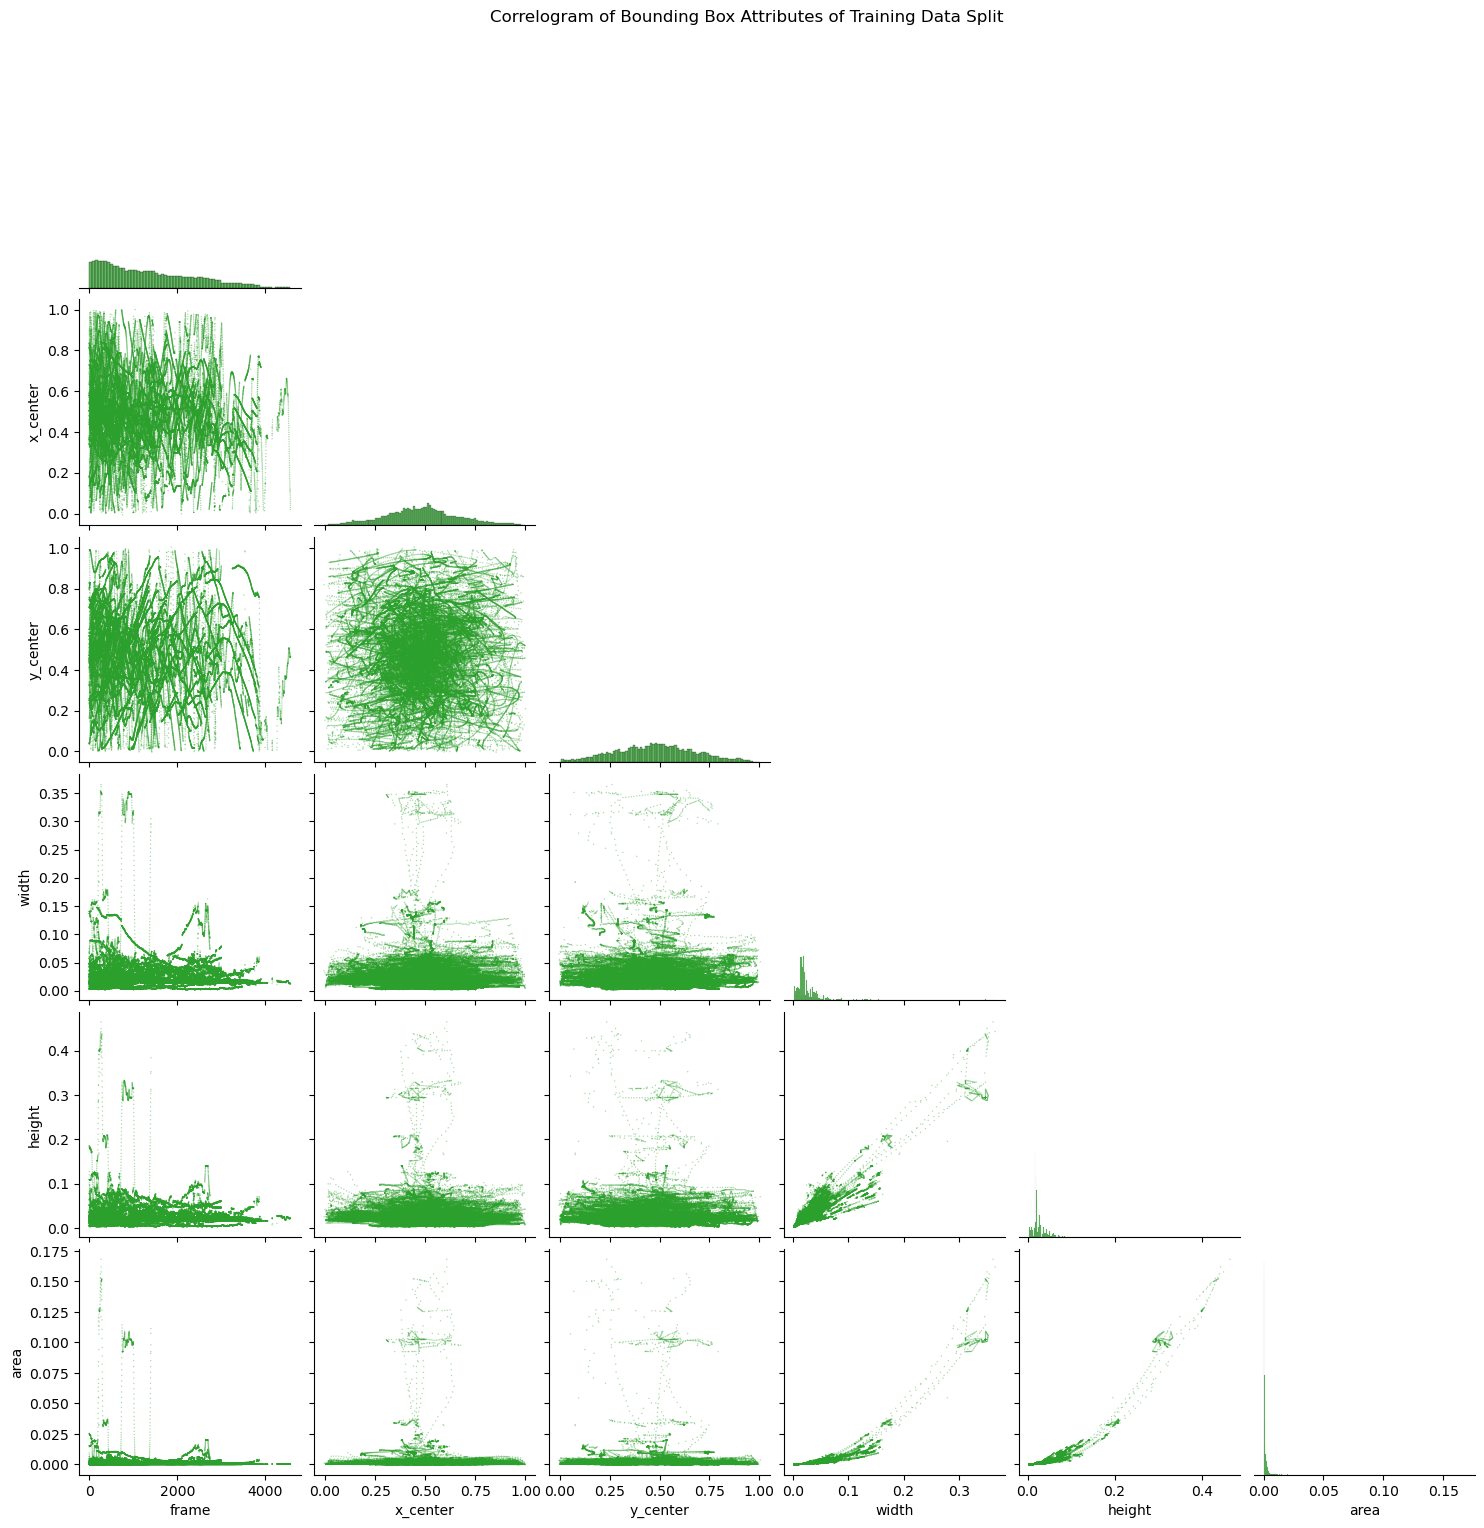

In [51]:
# Create a correlogram/pairplot chart of the training data

ann_trn = ann_data_df[ann_data_df['split'] == 'train']

# Create the base pairplot
trn_g =sns.pairplot(
    data=ann_trn[['frame', 'x_center', 'y_center', 'width', 'height', 'area']],
    markers='.',
    corner=True,
    diag_kws=dict(color='tab:green'),
    plot_kws=dict(c='tab:green',
                  edgecolor="none",
                  s=4,
                  alpha=0.4)
    )
# Set the title of the figure
trn_g.figure.suptitle('Correlogram of Bounding Box Attributes of Training Data Split', y=1.02)
# Save the figure to the metadata folder
trn_g.savefig(os.path.join(utils.METADATA_DIR, 'train_data_correlogram.png'), dpi=300, bbox_inches='tight')
# Display in-line
trn_g

In [56]:
ann_trn.describe()

,frame,label,x_center,y_center,width,height,area
count,97825.000000,97825.0,97825.000000,97825.000000,97825.000000,97825.000000,97825.000000
mean,1345.096141,0.0,0.483690,0.482120,0.028416,0.029240,0.001536
std,1002.625329,0.0,0.181328,0.205233,0.028823,0.026976,0.006982
min,0.000000,0.0,-0.004687,-0.005208,0.002083,0.002778,0.000007
25%,480.000000,0.0,0.365278,0.338657,0.015104,0.017361,0.000265
50%,1148.000000,0.0,0.482552,0.482639,0.020833,0.022569,0.000473
75%,2067.000000,0.0,0.593750,0.623264,0.033854,0.032986,0.001034
max,4569.000000,0.0,0.999609,1.006076,0.365365,0.464815,0.168132


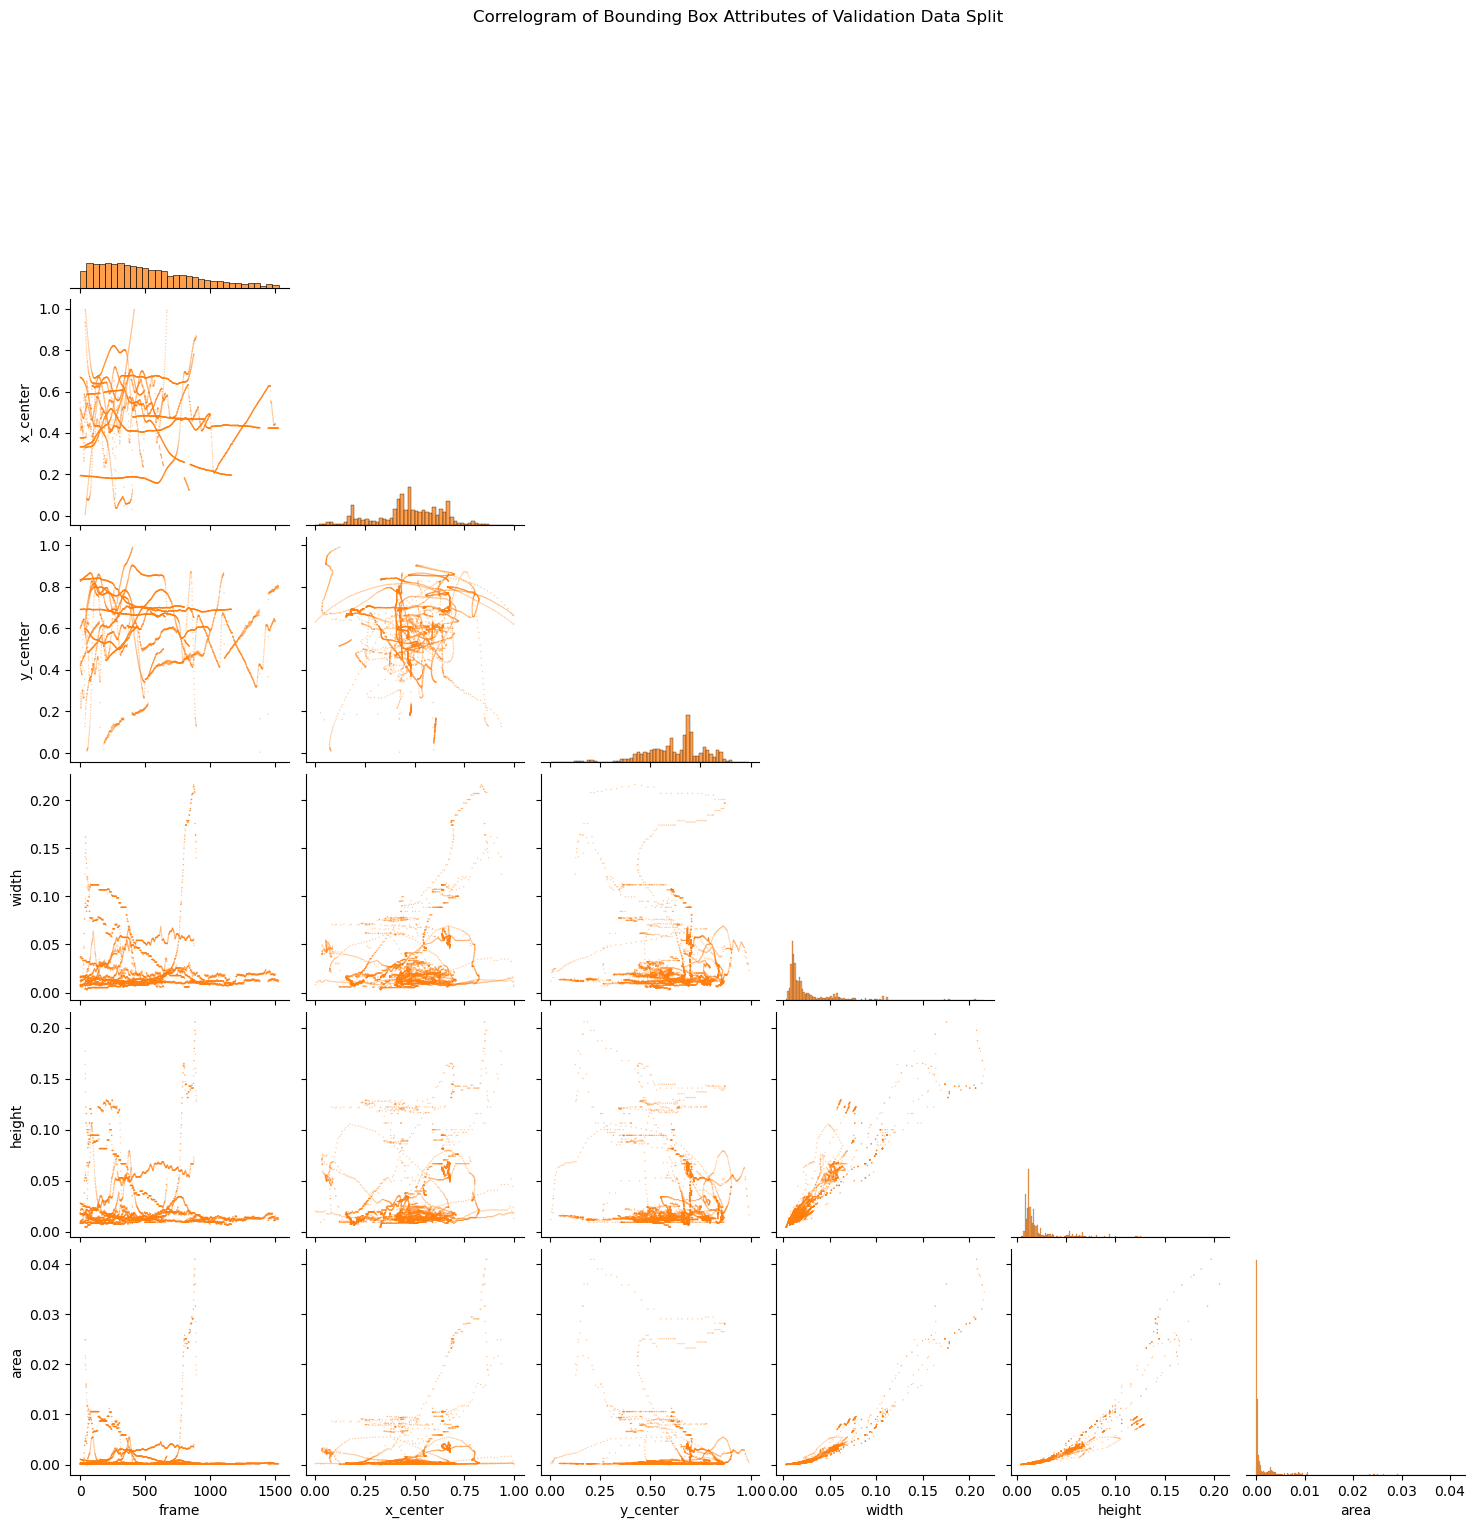

In [52]:
# Create a correlogram/pairplot chart of the validation data

ann_val = ann_data_df[ann_data_df['split'] == 'val']

# Create the base pairplot
val_g =sns.pairplot(
    data=ann_val[['frame', 'x_center', 'y_center', 'width', 'height', 'area']],
    markers='.',
    corner=True,
    diag_kws=dict(color='tab:orange'),
    plot_kws=dict(c='tab:orange',
                  edgecolor="none",
                  s=4,
                  alpha=0.4)
    )
# Set the title of the figure
val_g.figure.suptitle('Correlogram of Bounding Box Attributes of Validation Data Split', y=1.02)
# Save the figure to the metadata folder
val_g.savefig(os.path.join(utils.METADATA_DIR, 'val_data_correlogram.png'), dpi=300, bbox_inches='tight')
# Display in-line
val_g

In [55]:
ann_val.describe()

,frame,label,x_center,y_center,width,height,area
count,9866.000000,9866.0,9866.000000,9866.000000,9866.000000,9866.000000,9866.000000
mean,511.882222,0.0,0.472701,0.619433,0.025524,0.026412,0.001377
std,358.971673,0.0,0.167803,0.157022,0.027806,0.027495,0.003514
min,0.000000,0.0,0.004167,0.004167,0.003125,0.004630,0.000014
25%,224.000000,0.0,0.404232,0.528241,0.010417,0.012037,0.000122
50%,441.000000,0.0,0.473958,0.657870,0.014583,0.014815,0.000216
75%,738.000000,0.0,0.596354,0.705093,0.027083,0.025000,0.000694
max,1525.000000,0.0,0.996875,0.991667,0.216146,0.205556,0.040985


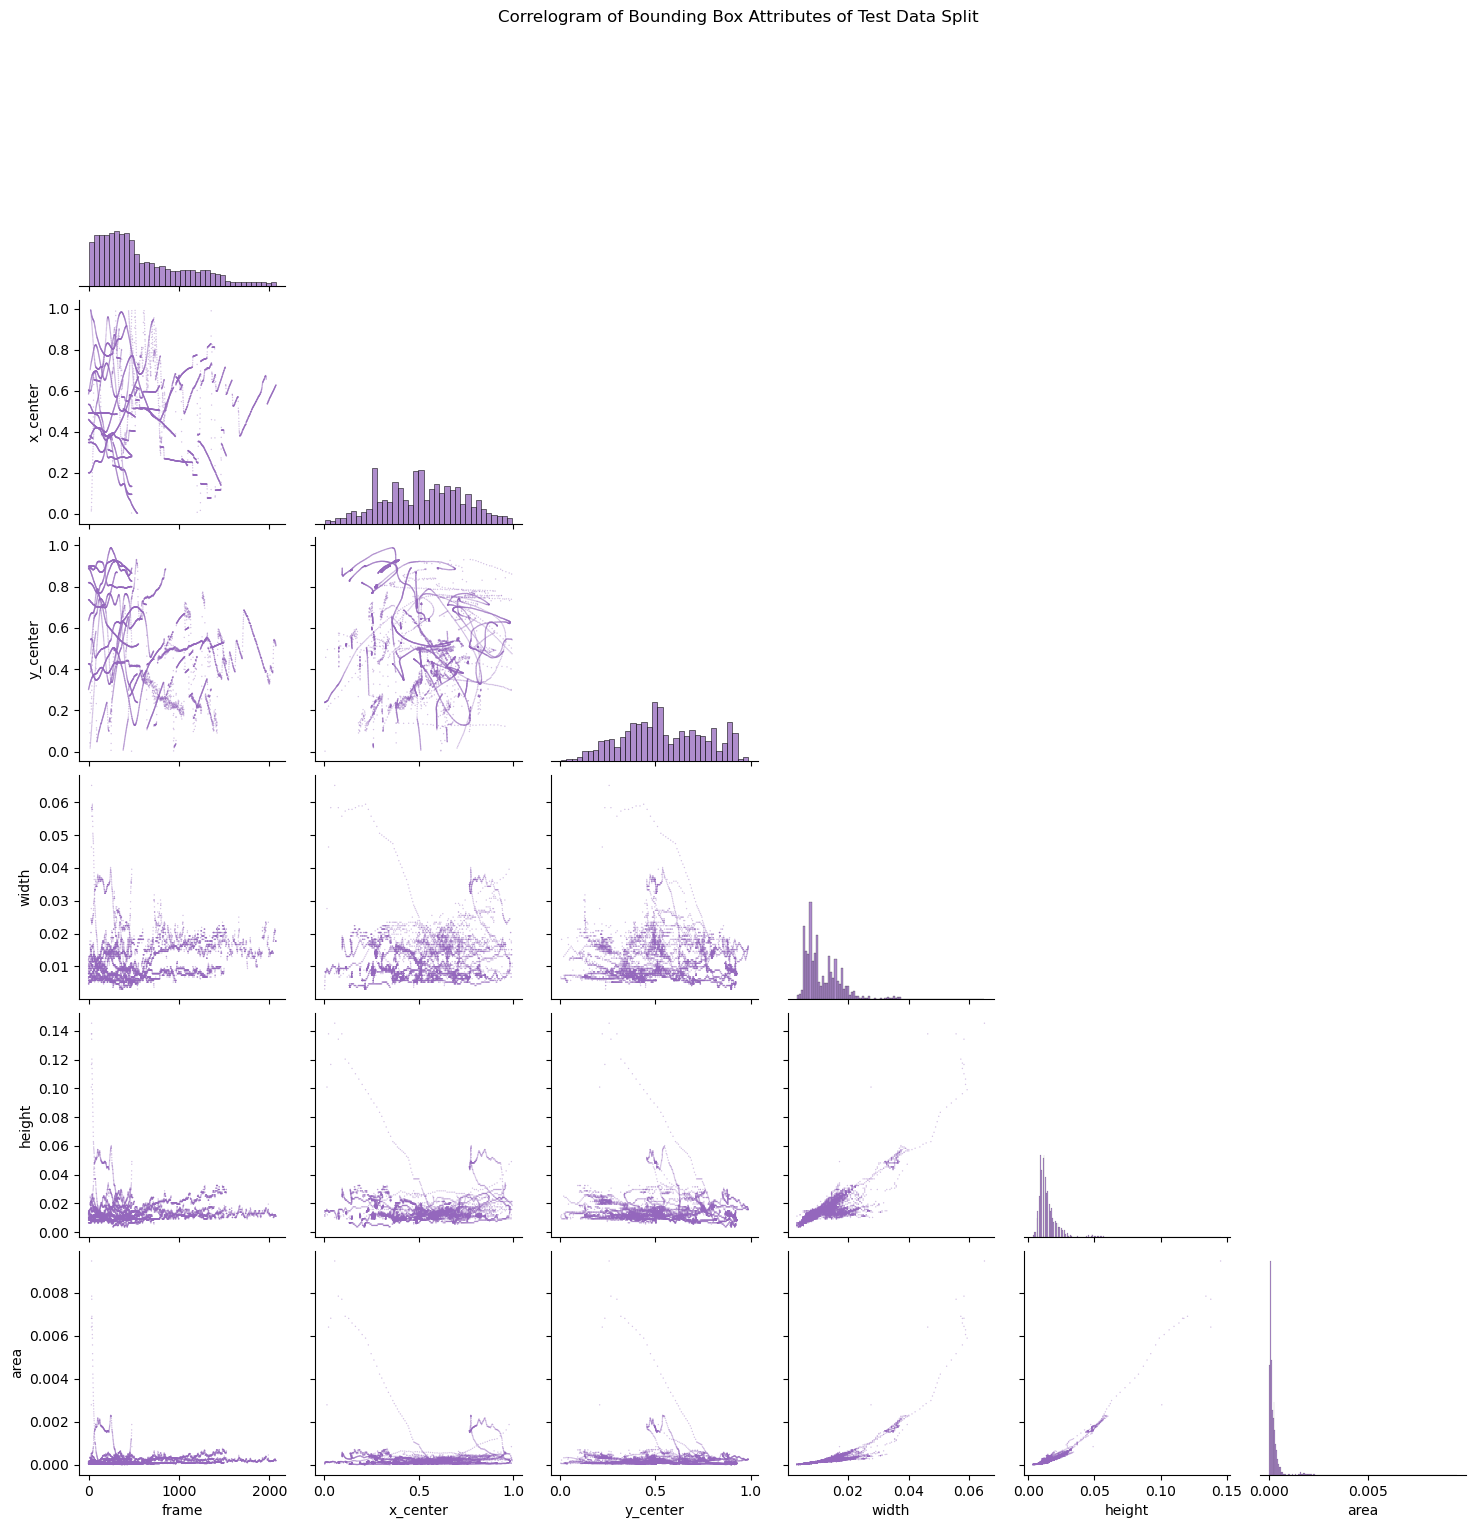

In [ ]:
# Create a correlogram/pairplot chart of the test data

ann_test = ann_data_df[ann_data_df['split'] == 'test']

# Create the base pairplot
test_g = sns.pairplot(
    data=ann_test[['frame', 'x_center', 'y_center', 'width', 'height', 'area']],
    markers='.',
    corner=True,
    diag_kws=dict(color='tab:purple'),
    plot_kws=dict(c='tab:purple',
                  edgecolor="none",
                  s=4,
                  alpha=0.4)
    )
# Set the title of the figure
test_g.figure.suptitle('Correlogram of Bounding Box Attributes of Test Data Split', y=1.02)
# Save the figure to the metadata folder
test_g.savefig(os.path.join(utils.METADATA_DIR, 'test_data_correlogram.png'), dpi=300, bbox_inches='tight')
# Display in-line
test_g

In [54]:
ann_test.describe()

,frame,label,x_center,y_center,width,height,area
count,11544.000000,11544.0,11544.000000,11544.000000,11544.000000,11544.000000,11544.000000
mean,592.744023,0.0,0.517368,0.542550,0.011811,0.014671,0.000218
std,474.070670,0.0,0.210061,0.217406,0.006355,0.008440,0.000366
min,0.000000,0.0,0.001563,0.002778,0.003125,0.003704,0.000012
25%,230.000000,0.0,0.362240,0.387037,0.007292,0.010185,0.000074
50%,443.000000,0.0,0.513281,0.516204,0.009375,0.012037,0.000122
75%,874.000000,0.0,0.675000,0.713426,0.015104,0.016667,0.000257
max,2074.000000,0.0,0.995052,0.988426,0.065104,0.145370,0.009464


C:\Users\keyan\AppData\Local\Temp\ipykernel_41908\3519990475.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  x_bp = sns.boxplot(


<Axes: xlabel='split', ylabel='x_center'>

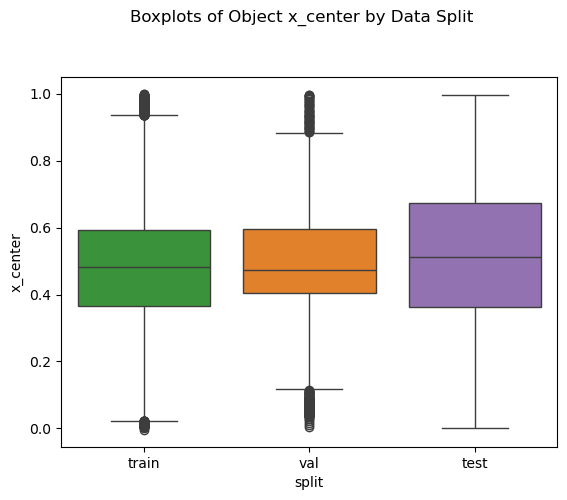

In [64]:
# Create boxplots for the x_center attribute of the annotations separated by split

x_bp = sns.boxplot(
    data=ann_data_df,
    x='split',
    y='x_center',
    orient='v',
    palette={'train': 'tab:green', 'val': 'tab:orange', 'test': 'tab:purple'}
)
# Add a title to the figure
x_bp.figure.suptitle('Boxplots of Object x_center by Data Split', y=1.02)
# Save the figure to the metadata folder
x_bp.figure.savefig(os.path.join(utils.METADATA_DIR, 'x_center_by_split_boxplot.png'), dpi=300, bbox_inches='tight')
# Display the figure in-line
x_bp

C:\Users\keyan\AppData\Local\Temp\ipykernel_41908\3362799081.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  y_bp = sns.boxplot(


<Axes: xlabel='split', ylabel='y_center'>

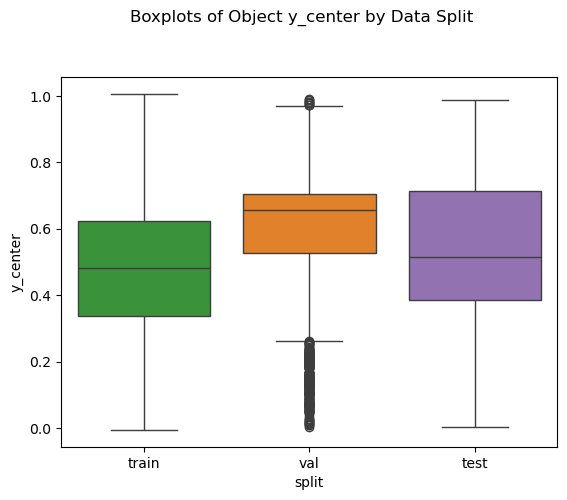

In [65]:
# Create boxplots for the y_center attribute of the annotations separated by split

y_bp = sns.boxplot(
    data=ann_data_df,
    x='split',
    y='y_center',
    orient='v',
    palette={'train': 'tab:green', 'val': 'tab:orange', 'test': 'tab:purple'}
)
# Add a title to the figure
y_bp.figure.suptitle('Boxplots of Object y_center by Data Split', y=1.02)
# Save the figure to the metadata folder
y_bp.figure.savefig(os.path.join(utils.METADATA_DIR, 'y_center_by_split_boxplot.png'), dpi=300, bbox_inches='tight')
# Display the figure in-line
y_bp

C:\Users\keyan\AppData\Local\Temp\ipykernel_41908\708561988.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  h_bp = sns.boxplot(


<Axes: xlabel='split', ylabel='height'>

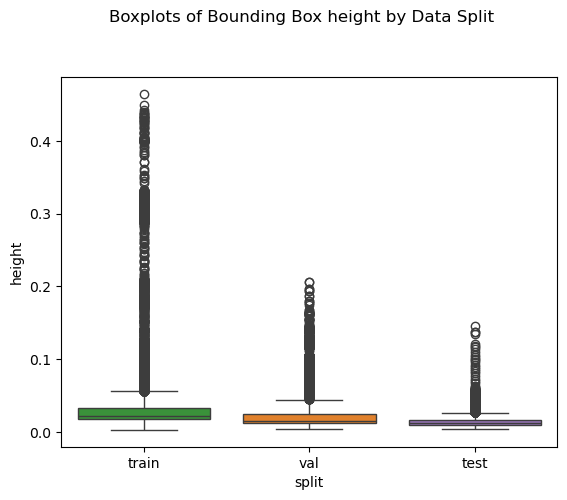

In [66]:
# Create boxplots for the height attribute of the annotations separated by split

h_bp = sns.boxplot(
    data=ann_data_df,
    x='split',
    y='height',
    orient='v',
    palette={'train': 'tab:green', 'val': 'tab:orange', 'test': 'tab:purple'}
)
# Add a title to the figure
h_bp.figure.suptitle('Boxplots of Bounding Box height by Data Split', y=1.02)
# Save the figure to the metadata folder
h_bp.figure.savefig(os.path.join(utils.METADATA_DIR, 'height_by_split_boxplot.png'), dpi=300, bbox_inches='tight')
# Display the figure in-line
h_bp

C:\Users\keyan\AppData\Local\Temp\ipykernel_41908\2052397863.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  w_bp = sns.boxplot(


<Axes: xlabel='split', ylabel='width'>

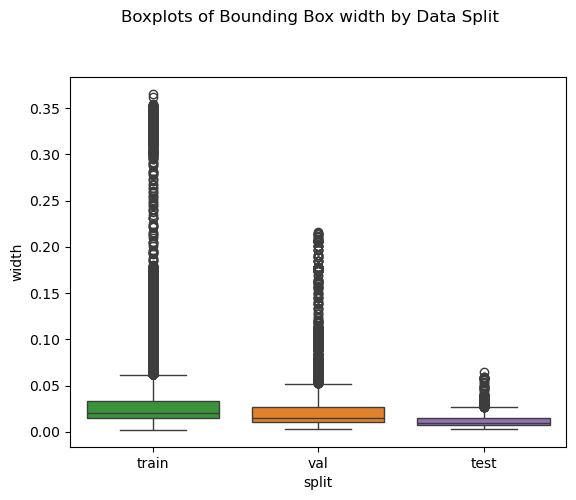

In [67]:
# Create boxplots for the width attribute of the annotations separated by split

w_bp = sns.boxplot(
    data=ann_data_df,
    x='split',
    y='width',
    orient='v',
    palette={'train': 'tab:green', 'val': 'tab:orange', 'test': 'tab:purple'}
)
# Add a title to the figure
w_bp.figure.suptitle('Boxplots of Bounding Box width by Data Split', y=1.02)
# Save the figure to the metadata folder
w_bp.figure.savefig(os.path.join(utils.METADATA_DIR, 'width_by_split_boxplot.png'), dpi=300, bbox_inches='tight')
# Display the figure in-line
w_bp

C:\Users\keyan\AppData\Local\Temp\ipykernel_41908\407829033.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  a_bp = sns.boxplot(


<Axes: xlabel='split', ylabel='area'>

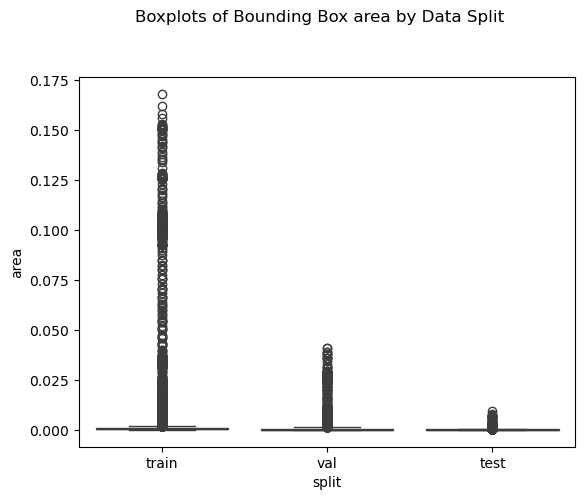

In [68]:
# Create boxplots for the area attribute of the annotations separated by split

a_bp = sns.boxplot(
    data=ann_data_df,
    x='split',
    y='area',
    orient='v',
    palette={'train': 'tab:green', 'val': 'tab:orange', 'test': 'tab:purple'}
)
# Add a title to the figure
a_bp.figure.suptitle('Boxplots of Bounding Box area by Data Split', y=1.02)
# Save the figure to the metadata folder
a_bp.figure.savefig(os.path.join(utils.METADATA_DIR, 'area_by_split_boxplot.png'), dpi=300, bbox_inches='tight')
# Display the figure in-line
a_bp

Based on the correlograms and the box plots comparing the different factors of the annotations the data splits should be sufficient. While the training data exhibits greater diversity in the height and width (or size) of the bounding boxes since the validation and test sets are not outside of the training set's range it should be a worthwhile split though it should be understood that the metrics from the test set will judge how well the model performs on detecting relatively smaller objects. Even so, the bulk of the data overlaps more closely.

In [69]:
# Get the list of images
image_files = utils.files.get_image_files(os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data'))

In [70]:
# Get the list of annotations
annotation_files = utils.files.get_annotation_files(os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data'))

In [71]:
# Split the image_files list into a training, validation, and test list
train_images = [f for f in image_files if any(train_file in f for train_file in train_files)]
val_images = [f for f in image_files if any(val_file in f for val_file in val_files)]
test_images = [f for f in image_files if any(test_file in f for test_file in test_files)]
print("Total Training images:", len(train_images))
print("Total Validation images:", len(val_images))
print("Total Test images:", len(test_images))

Total Training images: 86521
Total Validation images: 10723
Total Test images: 10725


In [72]:
# Split the annotation_files list into a training, validation, and test list
train_annotations = [f for f in annotation_files if any(train_file in f for train_file in train_files)]
val_annotations = [f for f in annotation_files if any(val_file in f for val_file in val_files)]
test_annotations = [f for f in annotation_files if any(test_file in f for test_file in test_files)]
print("Total Training annotations:", len(train_annotations))
print("Total Validation annotations:", len(val_annotations))
print("Total Test annotations:", len(test_annotations))

Total Training annotations: 86521
Total Validation annotations: 10723
Total Test annotations: 10725


In [76]:
# Move train_images to a train subfolder
for img in train_images:
    shutil.move(img, os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data', 'train', os.path.basename(img)))
for ann in train_annotations:
    shutil.move(ann, os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data', 'train', os.path.basename(ann)))

In [79]:
# Move val_images to a val subfolder
for img in val_images:
    shutil.move(img, os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data', 'val', os.path.basename(img)))
for ann in val_annotations:
    shutil.move(ann, os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data', 'val', os.path.basename(ann)))

In [81]:
# Move test_images to a test subfolder
for img in test_images:
    shutil.move(img, os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data', 'test', os.path.basename(img)))
for ann in test_annotations:
    shutil.move(ann, os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data', 'test', os.path.basename(ann)))

## 5. Image Size Adjustments

In [ ]:
# Collect a list of all image files

image_list = utils.image_data.get_image_files(os.path.join(utils.INTERIM_DATA_DIR, 'drone_vs_bird_data'))

length_initial = len(image_list)

print(f"Total number of images: {length_initial}")

In [ ]:
# Re-read the dataframe from the csv file
black_images_df = pd.read_csv(os.path.join(utils.METADATA_DIR, 'dvb_black_images.csv'))

In [ ]:
# Remove all blank images this should be 17 less than the previous total

image_list = [img for img in image_list if img not in black_images_df['file_name'].values]

length_remove_blanks = len(image_list)

print(f"Total number of images after removing blank images: {length_remove_blanks}")
print(f"Total removed: {length_initial - length_remove_blanks}")
print(f"Total identified blank images: {len(black_images_df)}")

In [ ]:
# If the image contains the test file name move it from the list to a new list
test_images = [img for img in image_list if utils.files.file_contains_name(img, test_files)]
training_images = [img for img in image_list if img not in test_images]

In [ ]:
# Do the same, splitting training into training and validation
val_images = [img for img in training_images if utils.files.file_contains_name(img, val_files)]
training_images = [img for img in training_images if img not in val_images]

In [ ]:
# Check list sizes

print(f"Total number of test images: {len(test_images)}")
print(f"Total number of validation images: {len(val_images)}")
print(f"Total number of training images: {len(training_images)}")

In [ ]:
# Duplicate the lists for the annotation files

test_annotations = test_images.copy()
val_annotations = val_images.copy()
training_annotations = training_images.copy()

# Change file extensions for each line to .txt
test_annotations = [os.path.splitext(ann)[0] + '.txt' for ann in test_annotations]
val_annotations = [os.path.splitext(ann)[0] + '.txt' for ann in val_annotations]
training_annotations = [os.path.splitext(ann)[0] + '.txt' for ann in training_annotations]

In [ ]:
# Set random seed for reproducibility
rng = np.random.default_rng(42)

# Get a random number in the range of the test set
random_test_index = rng.integers(0, len(test_images))

# Get a random number in the range of the validation set
random_validation_index = rng.integers(0, len(val_images))

# Get a random number in the range of the training set
random_training_index = rng.integers(0, len(training_images))

# Ensure that the test index gives matching image and annotations
print(f"Test image: {test_images[random_test_index]}")
print(f"Test annotation: {test_annotations[random_test_index]}")

# Ensure that the validation index gives matching image and annotations
print(f"Validation image: {val_images[random_validation_index]}")
print(f"Validation annotation: {val_annotations[random_validation_index]}")

# Ensure that the training index gives matching image and annotations
print(f"Training image: {training_images[random_training_index]}")
print(f"Training annotation: {training_annotations[random_training_index]}")
